# Linear Elastic Static Analysis for Portal Frames

In this notebook, i implement a straightforward workflow for performing elastic linear static analysis on moment frames with python. 

Stack:
- `OpenSeesPy` for analysis
- `Opsvis` for visualizing `OpenSeesPy`'s analysis results

## Sample Structure
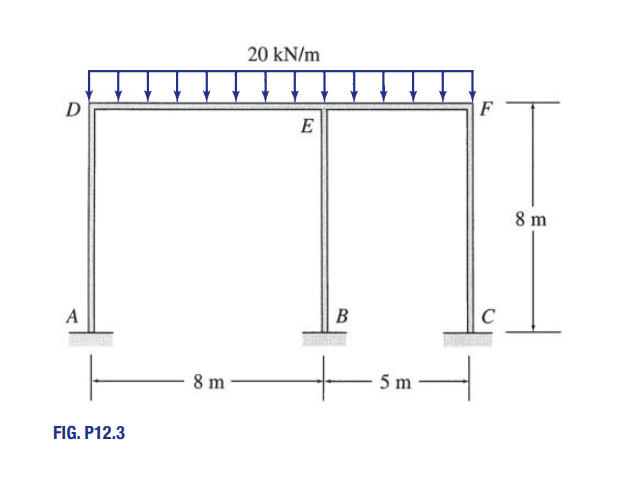

In [1]:
# OpenSeesPy and OpenSees
import openseespy.opensees as ops
import opsvis as opsv    # For visualization

import matplotlib.pyplot as plt

## Structure Data Entry and Constants

In [2]:
# Young's Modulus (N/mm^2)
E = 200*10**9

# Cross-Sectional area (m^2)
A = 0.03

# Second Moment of area (m^4)
Iz = 300*10**-6

# Structure geometry (m)
n_bays = 2
h_bay = 8
w_bay = [8, 5]

# Three degrees of freedom all fixed (Ux, Uy, theta_z)
fixity = (1, 1, 1)
# fixity = (1, 1, 0) if pin
# fixity = (0, 1, 0) if a roller

## OpeenSeesPy - Initialisation

In [3]:
# Remove any existing model from memory
ops.wipe()

# Initialize the model -- 2 dimensions and 3 degress of freedom per node
ops.model('basic', '-ndm', 2, '-ndf', 3)

## OpenSeesPy - Model Definition

### Nodes

In [4]:
# Initialize the x_coordinate
x_coord = 0

for i in range(n_bays + 1):
    index = i + 1
    # x_coord = i * w_bay

    # Base node
    nodeTag = (2 * index - 1)
    y_coord = 0
    ops.node(nodeTag, x_coord, y_coord)
    print(f'Base node with tag {nodeTag} is defined.')

    # Eaves node
    nodeTag = 2 * index
    y_coord = h_bay
    ops.node(nodeTag, x_coord, y_coord)
    print(f'Eaves node with tag {nodeTag} is defined.')

    # Update coordinates for the next node
    if i < n_bays:
        # Add current bay width
        x_coord += w_bay[i]

Base node with tag 1 is defined.
Eaves node with tag 2 is defined.
Base node with tag 3 is defined.
Eaves node with tag 4 is defined.
Base node with tag 5 is defined.
Eaves node with tag 6 is defined.


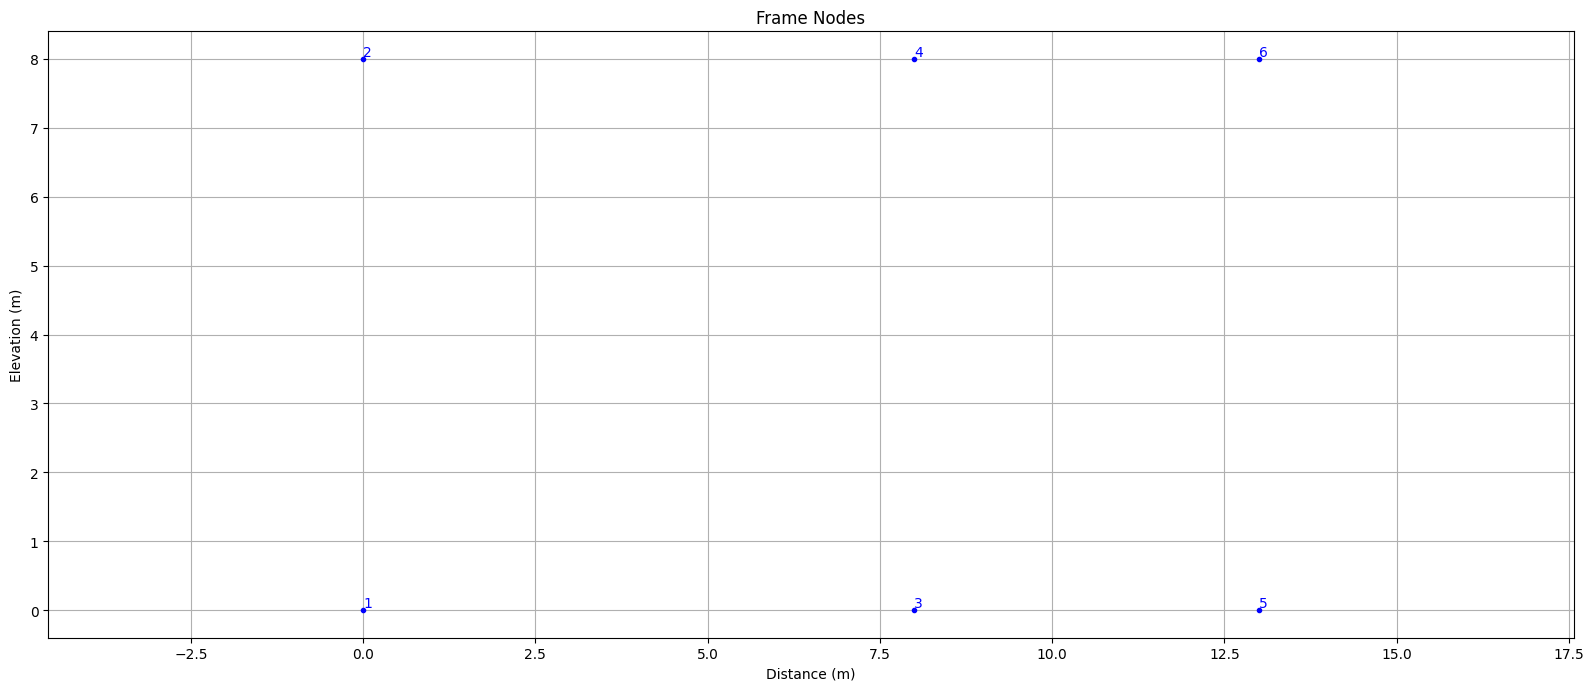

In [5]:
def plot_structure(title):
    """Helper function for making visualizations of the model with opsvis
    """
    opsv.plot_model(fig_wi_he=(50, 20))

    # Customization
    plt.title(title)
    plt.xlabel('Distance (m)')
    plt.ylabel('Elevation (m)')
    plt.grid()
    plt.show()

plot_structure('Frame Nodes')

### Elements

You need to define a `linear transform`. It's an object that maps the stiffness and actions from a local member reference frame to the global reference frame

In [6]:
# Transform type
transf_type = 'Linear'
transf_tag = 1   # One transform for all our elements
ops.geomTransf(transf_type, transf_tag)

If it's a 3d model, and you want to define an element, 

Define a local z for your element in the global reference frame.
e.g `vec_x_z`, `z` is pointing out of the screen you would do `(0, 0, 1)`

Column element with tag 1 defined
Column element with tag 2 defined
Column element with tag 3 defined
Beam/Rafter element with tag 4 defined
Beam/Rafter element with tag 5 defined


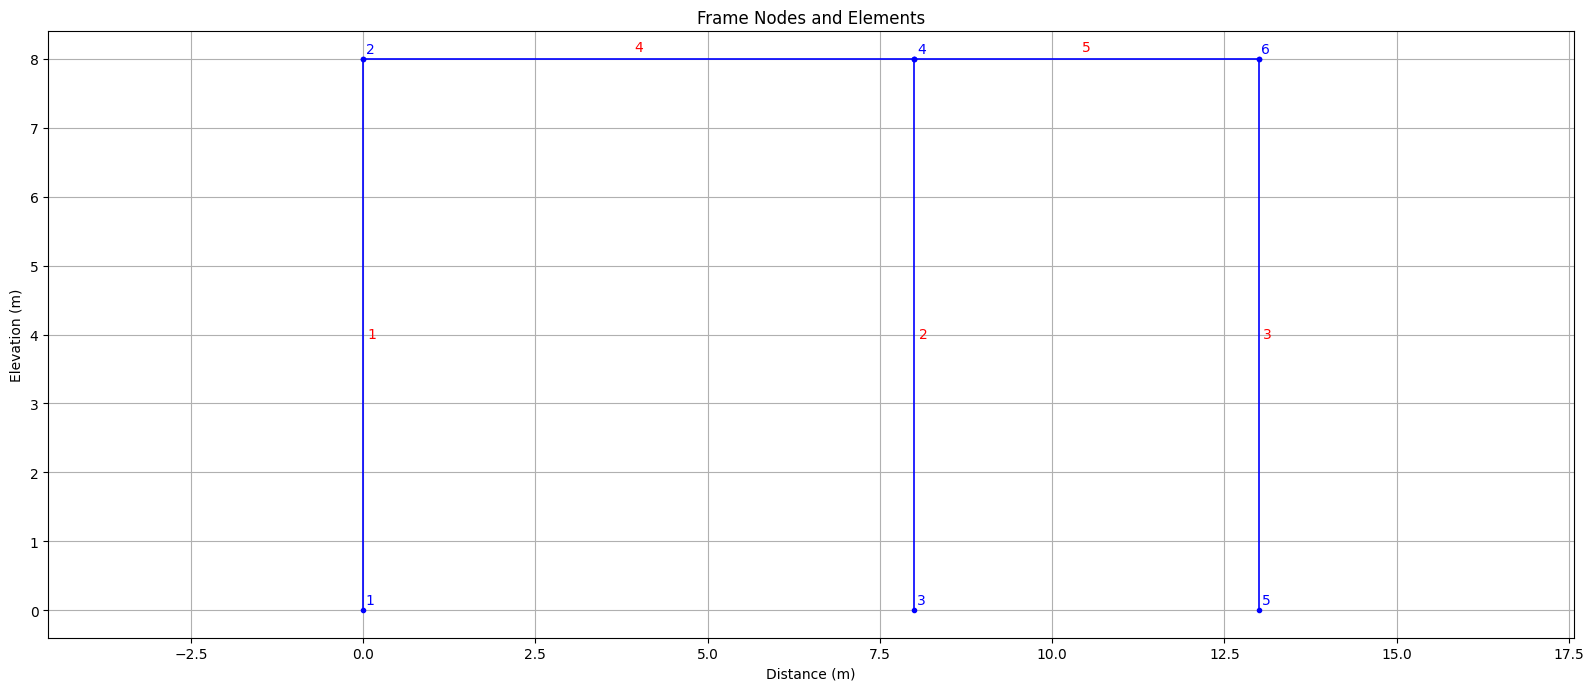

In [7]:
# Define Columns
for i in range(n_bays + 1):
    element_tag = i + 1    # Element tag
    end_bottom = (2 * element_tag) - 1    # Node at the base
    end_top = 2 * element_tag    # Node at the top

    # Create the column
    ops.element('elasticBeamColumn', element_tag, end_bottom, end_top, A, E, Iz, transf_tag)
    print(f'Column element with tag {element_tag} defined')

# Define horizontal members (beam/rafters)
for i in range(n_bays):
    index = i + 1
    element_tag = n_bays + 1 + index   # Element tag
    end_left = 2 * index
    end_right = 2 * index + 2

    # Create the rafter
    ops.element('elasticBeamColumn', element_tag, end_left, end_right, A, E, Iz, transf_tag)
    print(f'Beam/Rafter element with tag {element_tag} defined')

plot_structure('Frame Nodes and Elements')

### Supports

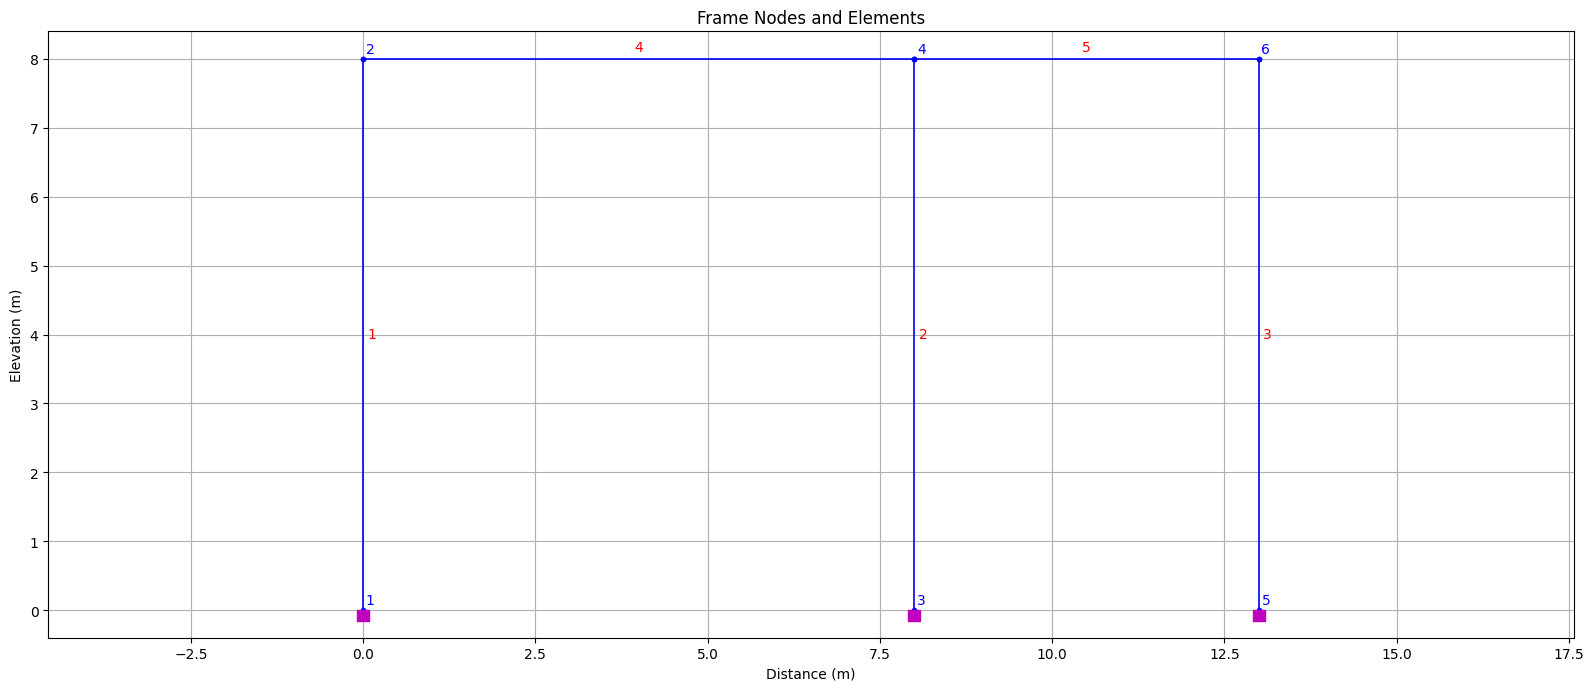

In [8]:
# for i in range(n_bays + 1):
#     index = i + 1
#     nodeTag = int((2 + index) + 1)

#     # Define a tag + node fixity to pass into ops' method
#     node_fixity = (nodeTag,) + fixity   # (nodetag, 1, 1, 1)
#     ops.fix(*node_fixity)
# Create supports
ops.fix(*((1,) + fixity))
ops.fix(*((3,) + fixity))
ops.fix(*((5,) + fixity))

plot_structure('Frame Nodes and Elements')

### Load Definition


In [9]:
# Create a timeseries object
time_series = ops.timeSeries('Constant', 1)

# Deifne Load pattern
ops.pattern('Plain', 1, 1)

# Create element load
# ops.eleLoad('-ele', 4, '-type', '-beamUniform', -20000)
# ops.eleLoad('-ele', 5, '-type', '-beamUniform', -20000)
ops.eleLoad('ele', '-range', 4, 5, '-type', '-beamUniform', -20000)    # Create a distributed load ranging from mem ele 4 to ele 5

# Point load load(point=2x, load+20000, 0y, 0z)

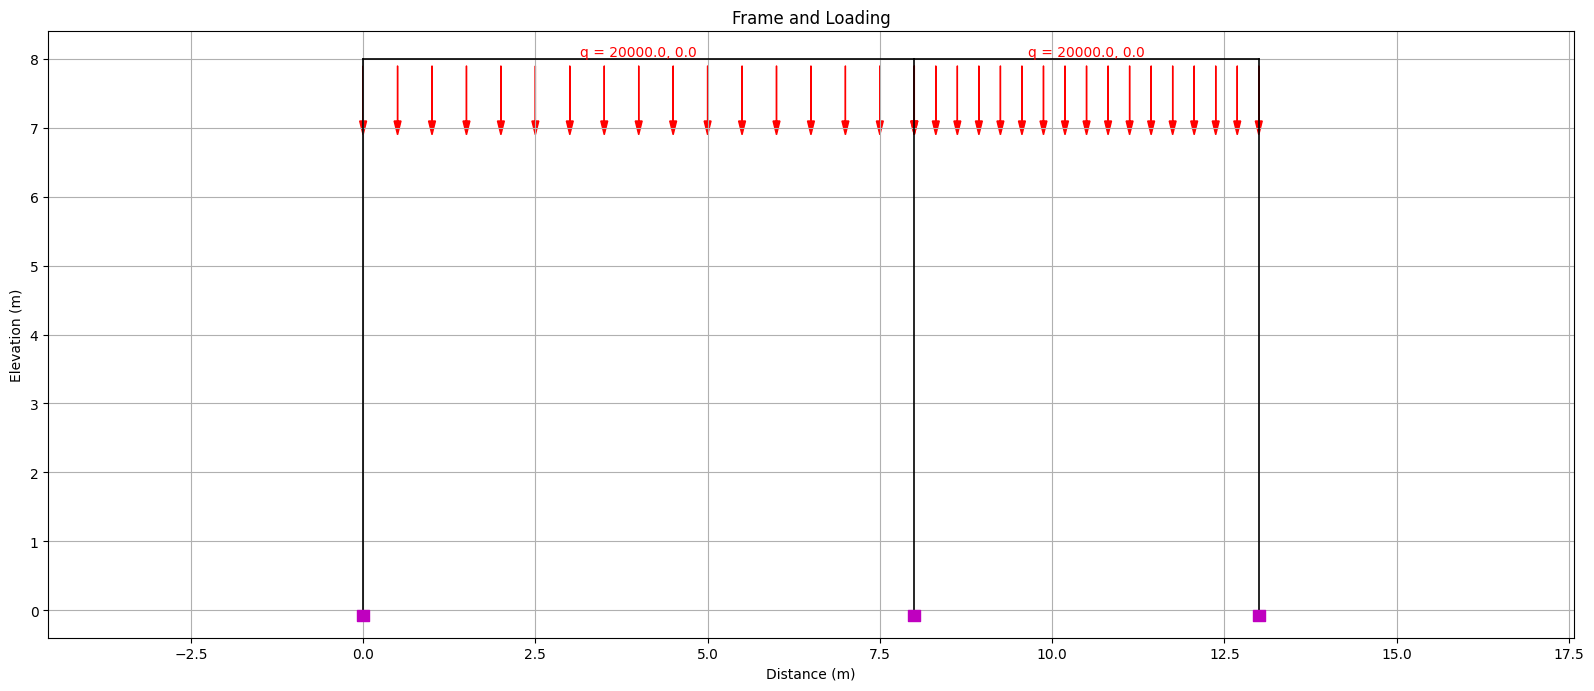

In [10]:
def plot_loads(title):
    """Helper function for making visualizations of the model with opsvis, plotting loads in the model
    """
    opsv.plot_loads_2d(sfac=True, fig_wi_he=(50, 20))

    # Customization
    plt.title(title)
    plt.xlabel('Distance (m)')
    plt.ylabel('Elevation (m)')
    plt.grid()
    plt.show()

plot_loads('Frame and Loading')

## Analysis

In [11]:
# Define a system of equations
ops.system('BandGeneral')

# Specifying a degree of freedom numberer
ops.numberer('RCM')

# Specify constraints
ops.constraints('Transformation')

# Specify an integrator (1 means that for each increment of load applied, apply to 1 single load application)
ops.integrator('LoadControl', 1)

# Specify an algorithm
ops.algorithm('Linear')

# Specify analysis type (Linear Static Analysis)
ops.analysis('Static')

# Analyze the model (1 indicates that we are doing a single step in our analysis)
ops.analyze(1)

0

### Deflection

You can use `sfac` with

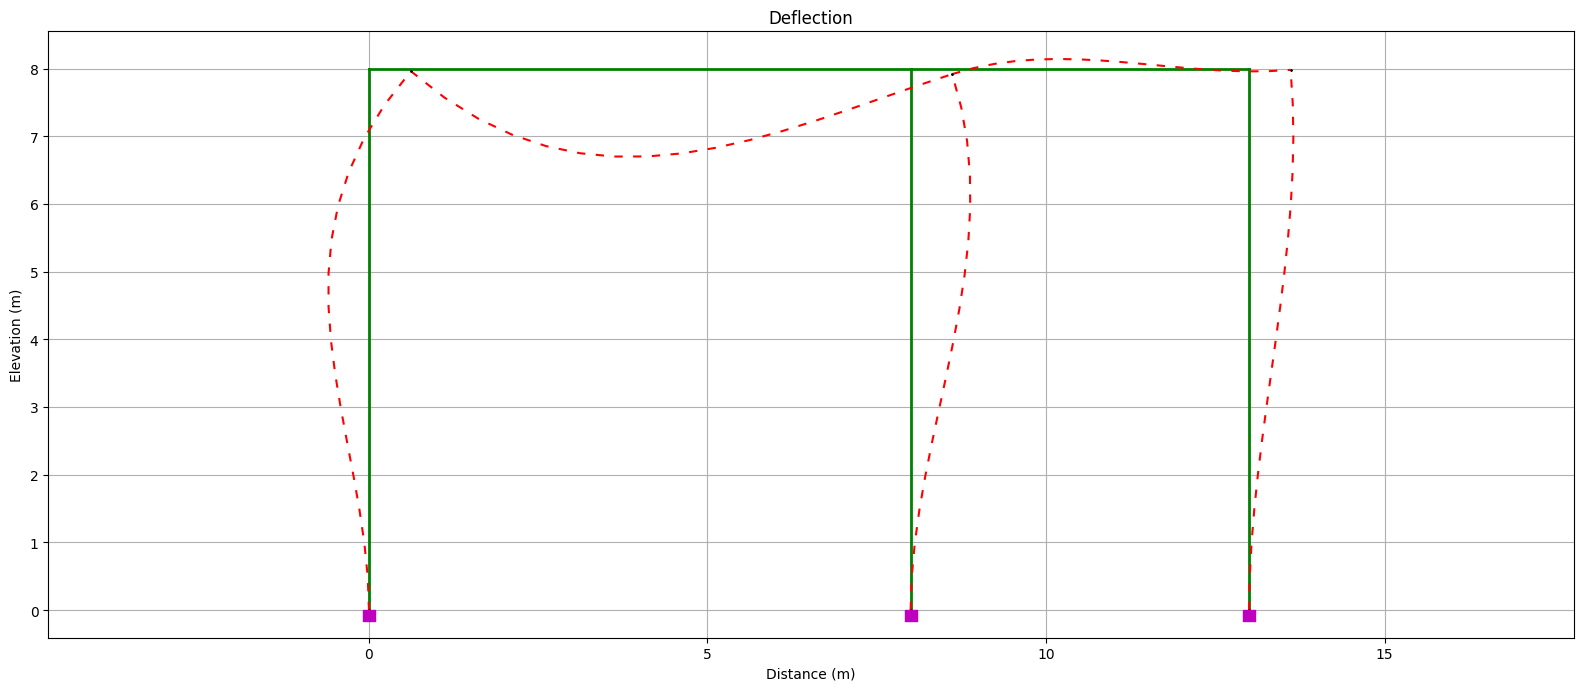

The scale factor on deflection is 409.52


In [12]:
s = opsv.plot_defo(
    fig_wi_he=(50, 20),
    fmt_defo={'color': 'red', 'linestyle': (0, (4, 5)), 'linewidth': 1.5},
    fmt_undefo={'color': 'green', 'linestyle': 'solid', 'linewidth': 2}
)

plt.title("Deflection")
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.grid()
plt.show()

print(f'The scale factor on deflection is {round(s, 2)}')

the scale factor means that the visualization is 409.52 times bigger than the actual deflection

### Bending Moment Diagram

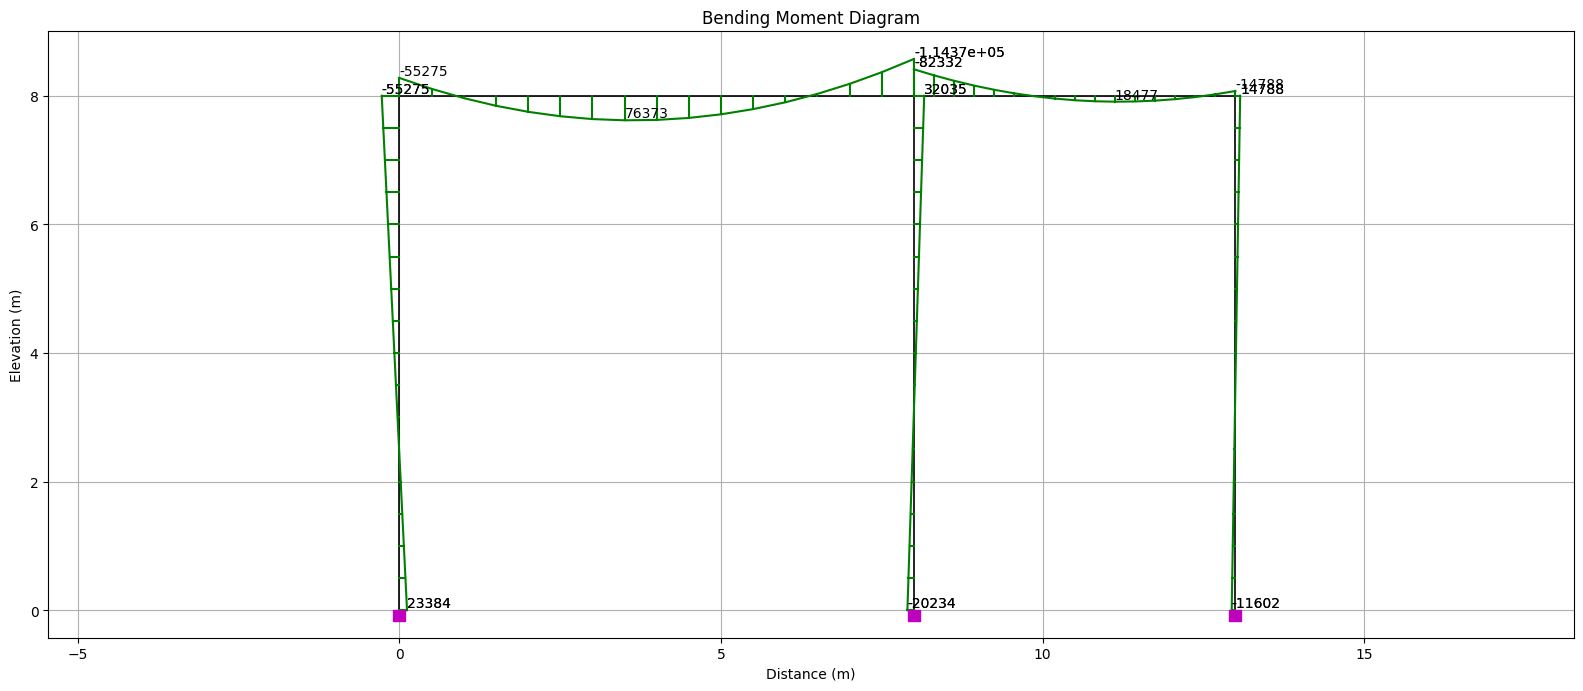

In [13]:
# Visualization scaling factor
m_fac = 5.e-6

opsv.section_force_diagram_2d('M', m_fac, fig_wi_he=(50, 20),
                             fmt_secforce1={'color': 'green'},
                             fmt_secforce2={'color': 'green'})

plt.title("Bending Moment Diagram")
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.grid()
plt.show()

### Shear Force Diagram



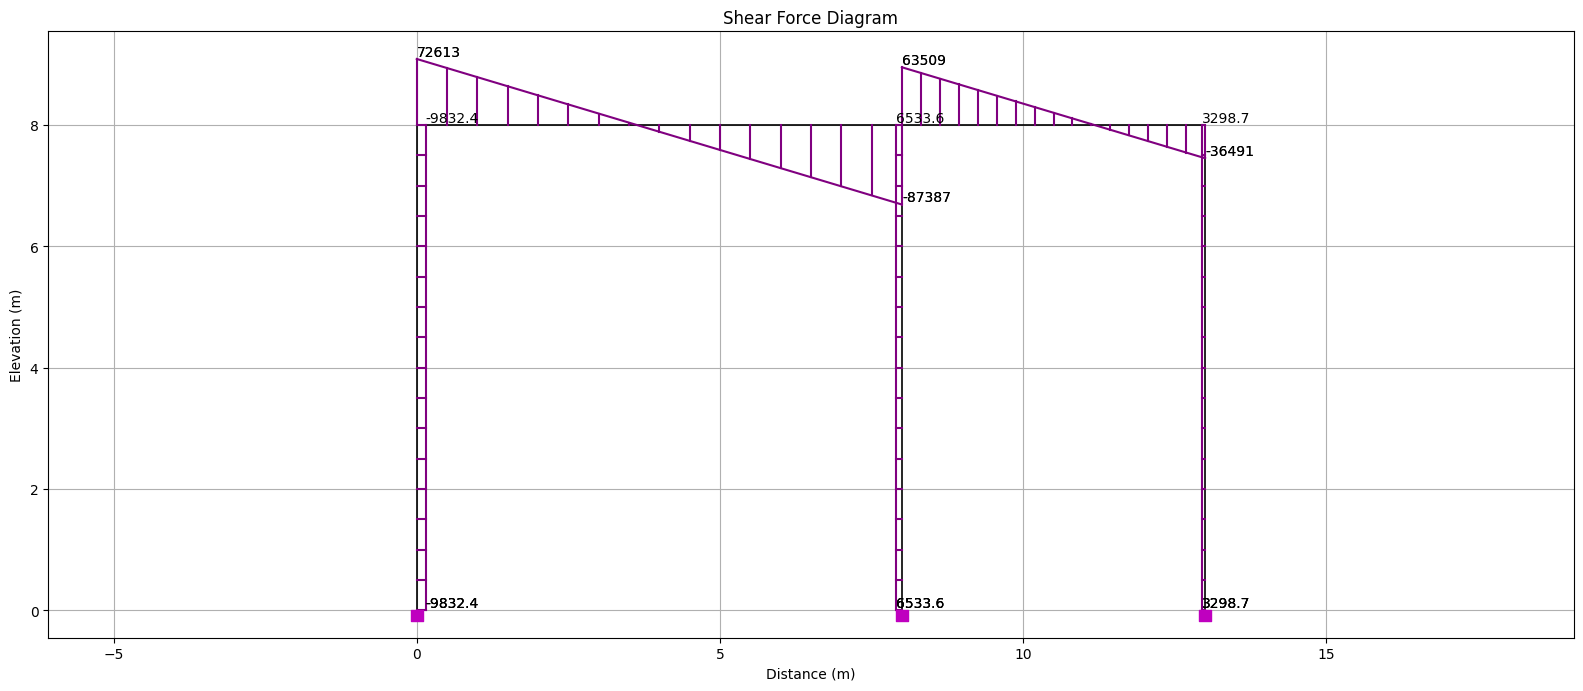

In [14]:
# Visualization scaling factor
m_fac = 15.e-6

opsv.section_force_diagram_2d('V', m_fac, fig_wi_he=(50, 20),
                             fmt_secforce1={'color': 'purple'},
                             fmt_secforce2={'color': 'purple'})

plt.title("Shear Force Diagram")
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.grid()
plt.show()

### Axial Force Diagram

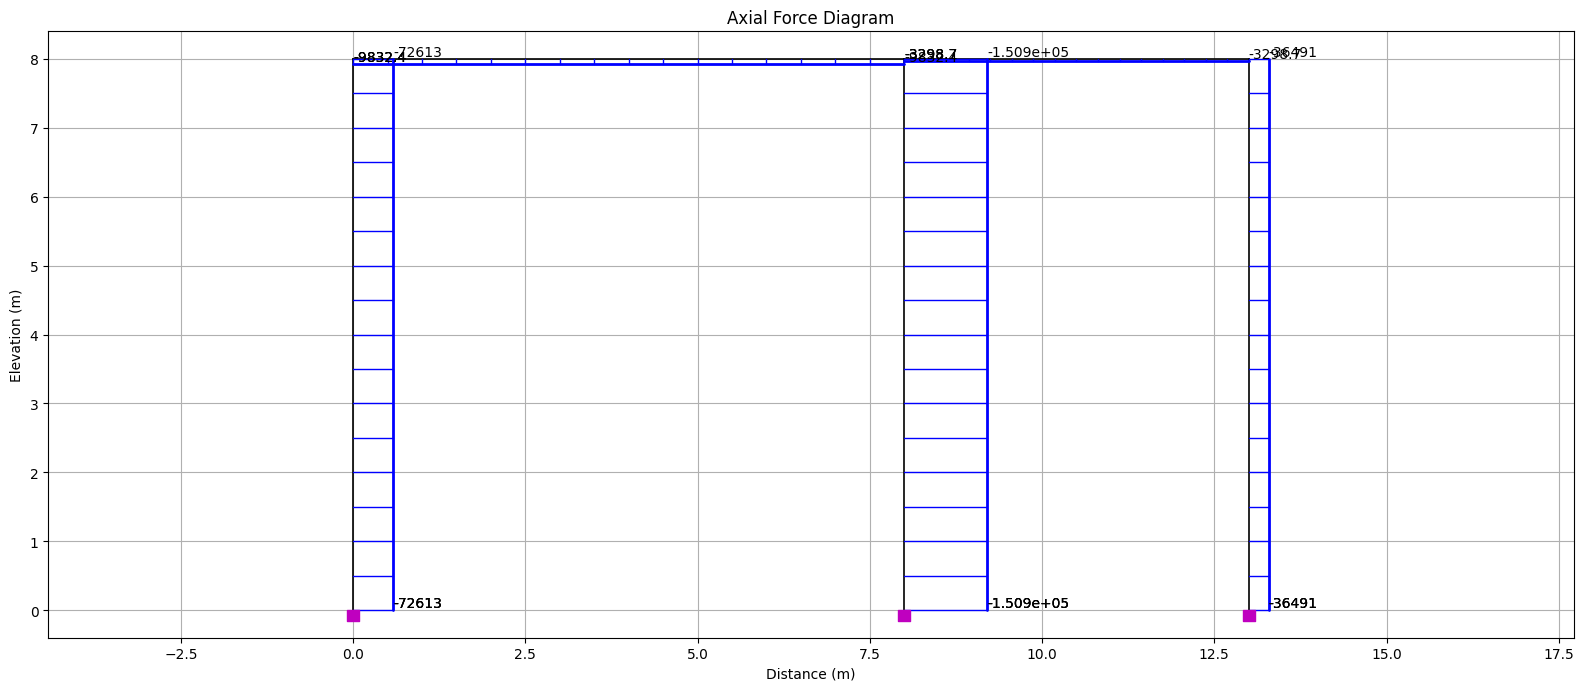

In [15]:
# Visualization scaling factor
m_fac = 8.e-6

opsv.section_force_diagram_2d('N', m_fac, fig_wi_he=(50, 20))

plt.title("Axial Force Diagram")
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.grid()
plt.show()

## Inspect Results

In [16]:
ops.printModel()

Current Domain Information
	Current Time: 1
	Committed Time: 1
NODE DATA: NumNodes: 6

numComponents: 6

 Node: 1
	Coordinates  : 0 0 
	Disps: 0 0 0 
	 unbalanced Load: 0 0 0 
	ID : -1 -1 -1 


 Node: 2
	Coordinates  : 0 8 
	Disps: 0.00151218 -9.6818e-05 -0.00212602 
	 unbalanced Load: 0 0 0 
	ID : 6 7 8 


 Node: 3
	Coordinates  : 8 0 
	Disps: 0 0 0 
	 unbalanced Load: 0 0 0 
	ID : -1 -1 -1 


 Node: 4
	Coordinates  : 8 8 
	Disps: 0.00149907 -0.000201194 0.000786767 
	 unbalanced Load: 0 0 0 
	ID : 3 4 5 


 Node: 5
	Coordinates  : 13 0 
	Disps: 0 0 0 
	 unbalanced Load: 0 0 0 
	ID : -1 -1 -1 


 Node: 6
	Coordinates  : 13 8 
	Disps: 0.00149633 -4.86549e-05 0.000212359 
	 unbalanced Load: 0 0 0 
	ID : 0 1 2 

ELEMENT DATA: NumEle: 5

numComponents: 5

ElasticBeam2d: 1
	Connected Nodes: 1 2 
	CoordTransf: 1
	mass density:  0, cMass: 0
	release code:  0
	End 1 Forces (P V M): 72613.5 -9832.37 -23384.3
	End 2 Forces (P V M): -72613.5 9832.37 -55274.6

ElasticBeam2d: 2
	Connected Nodes: 3

In [17]:
# Check results om node 2
ops.printModel('-node', 2)


 Node: 2
	Coordinates  : 0 8 
	Disps: 0.00151218 -9.6818e-05 -0.00212602 
	 unbalanced Load: 0 0 0 
	ID : 6 7 8 

